In [1]:
import sqlite3
import pandas as pd

In [2]:
# Connect to factbook.db
conn = sqlite3.connect("factbook.db")

In [3]:
# Get information about the tables in the database
q = "SELECT * FROM sqlite_master WHERE type='table';"
pd.read_sql_query(q, conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


In [4]:
# Get the first 5 rows of the facts table 
query1 = "SELECT * FROM facts LIMIT 5;"
pd.read_sql_query(query1, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


In [5]:
# Get min, max info 
query2 = "SELECT MIN(population), MAX(population), MIN(population_growth), MAX(population_growth) FROM facts;"
pd.read_sql_query(query2, conn)

,MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,0,7256490011,0.0,4.02


In [6]:
# Get countrie(s) with population = 0
query3 = "SELECT name from facts where population = 0;"
pd.read_sql_query(query3, conn)

,name
0,Antarctica


In [10]:
# Get countrie(s) with population = MAX
query4 = "SELECT name from facts where population == (SELECT MAX(population) from facts);"
pd.read_sql_query(query4, conn)

,name
0,World


Min Population is in Antarctica, which is not a counntry. Max population is in "World".  Looks wrong.

It doesn't make sense to include Antarctica and World as a part of the analysis. Thus, exclude them from further analysis.

In [12]:
query5 = '''
SELECT population, population_growth, birth_rate, death_rate \n
from facts where population != (SELECT MIN(population) from facts) \n
AND population != (SELECT MAX(population) from facts)
'''

data_for_hist = pd.read_sql_query(query5, conn)

In [16]:
# Plot histograms for these 4 columns
import matplotlib.pyplot as plt
%matplotlib inline

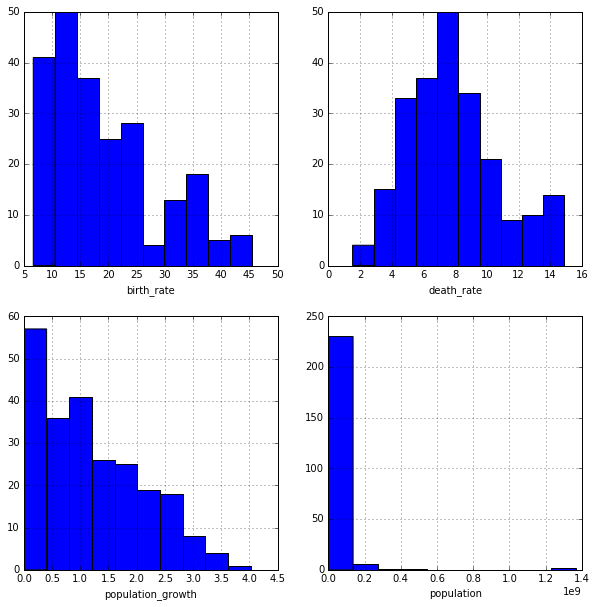

In [17]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

data_for_hist["birth_rate"].hist(ax=ax1)
ax1.set_xlabel("birth_rate")
data_for_hist["death_rate"].hist(ax=ax2)
ax2.set_xlabel("death_rate")
data_for_hist["population_growth"].hist(ax=ax3)
ax3.set_xlabel("population_growth")
data_for_hist["population"].hist(ax=ax4)
ax4.set_xlabel("population")

plt.show()

We see that birth_rate has a right skewed distribution while death_rate is almost normally distributed.

**Further Analysis**

Part 1 - Countries with high population densities

In [22]:
query6 = '''
SELECT name, CAST(population as float)/CAST(area as float) "density"
FROM facts
WHERE population != (SELECT MIN(population) from facts)
AND population != (SELECT MAX(population) from facts)
ORDER BY density DESC
'''

data_with_density = pd.read_sql_query(query6, conn)

In [26]:
data_with_density.head(20)

,name,density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8141.279770
3,Hong Kong,6445.041516
4,Gaza Strip,5191.819444
5,Gibraltar,4876.333333
6,Bahrain,1771.859211
7,Maldives,1319.640940
8,Malta,1310.015823
9,Bermuda,1299.925926


We see that small (city sized) countries which have huge populations top this chart which is quite expected.

Plotting Histogram for Population Density

In [31]:
# Exclude countries with area zero to avoid NaN density values

query6b = '''
SELECT name, CAST(population as float)/CAST(area as float) "density"
FROM facts
WHERE population != (SELECT MIN(population) from facts)
AND population != (SELECT MAX(population) from facts)
AND area != 0;
'''

data_with_density_unsorted = pd.read_sql_query(query6b, conn)

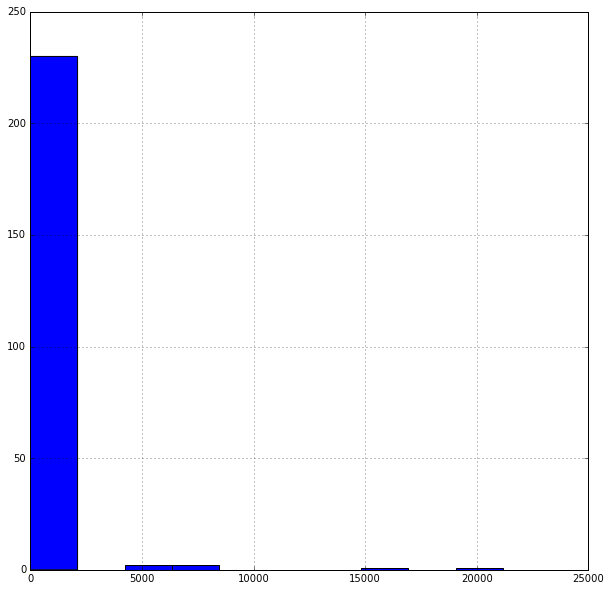

In [32]:
fig = plt.figure(figsize=(10,10))

data_with_density_unsorted["density"].hist()
plt.show()

This is hard to read, limit the histogram and increase the number of bins.

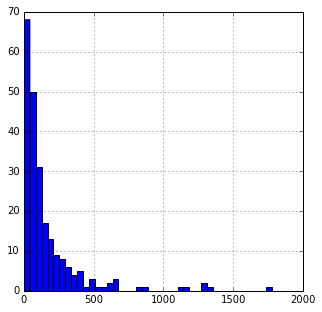

In [33]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

data_with_density_unsorted['density'].hist(bins=500)
ax.set_xlim(0, 2000)
plt.show()

We can clearly see that some countries (most likely city states) have much higher population density that many other countries

Part 2 - Country area analysis

In [42]:
# Countries with highest ratio of water to land
query7 = '''
SELECT name, CAST(area_water as float)/CAST(area_land as float) "ratio_w_to_l"
FROM facts
WHERE population != (SELECT MIN(population) from facts)
AND population != (SELECT MAX(population) from facts)
AND area != 0
ORDER BY ratio_w_to_l DESC;
'''

data_with_water_to_land_ratio = pd.read_sql_query(query7, conn)

In [43]:
data_with_water_to_land_ratio.head(10)

,name,ratio_w_to_l
0,Virgin Islands,4.520231
1,Puerto Rico,0.554791
2,"Bahamas, The",0.386613
3,Guinea-Bissau,0.284673
4,Malawi,0.259396
5,Netherlands,0.225710
6,Uganda,0.222922
7,Eritrea,0.164356
8,Liberia,0.156240
9,Bangladesh,0.140509


Country with highest ratio of water to land - Virgin Islands. We see that mostly island countries have a high ratio.
With ~4.5 water than land, Virgin Islands has much more water than land.